In [290]:
import numpy as np
import matplotlib.pyplot as plt


################## f et derrivée de f##################################################################
def f(u):
    #return (-u**2)/2
    return (u**2)/2
    #return u**3
def df(u):
    #return -u
    return u
    #return 3*(u**2)

In [292]:
def u0_initiale(x, ul, ur):
    return np.piecewise(x, [x < 0.5, x >= 0.5], [ul, ur])

###################################condition intiale sinusoidale #####################################################

def u0(x):
    return np.sin(2*np.pi*x)

In [294]:

################ Condition aux limites de type Neumann et Periodique ############################
#def apply_boundary_conditions(u, mode="Neumann"):
    #if mode == "Neumann":
        #u[0] = u[1]
        #u[-1] = u[-2]
    #elif mode == "Periodique":
        #u[0] = u[-2]
        #u[-1] = u[1]
    #return u

def Neumann(u):
    u[0] = u[1]
    u[-1] = u[-2]
    return u

def Periodique(u):
    u[0] = u[-2]
    u[-1] = u[1]
    return u


In [296]:
############# Flux de Godunov , Rusanov et Roe dans le cas scalaire ##########################
def Flux_Godunov(ul, ur):
    if ul* ur> 0:
        if ul < ur:
            return np.min([f(ul), f(ur)])
        else:
            return np.max([f(ul), f(ur)])
    else:
        return 0
############# Rusanov  dans le cas scalaire ##########################
def Flux_Rusanov(ul , ur):
    a = np.max([np.abs(df(ul)) , np.abs(df(ur))])
    return 0.5*(f(ul)+f(ur))- 0.5*a*(ur-ul)

############# Roe dans le cas scalaire ##########################
def Flux_Roe(ul, ur):
    if ul != ur:
        a = (f(ur) - f(ul)) / (ur - ul)   
        return 0.5 * ((f(ul) + f(ur)) - np.abs(a) * (ur- ul))
    else:
        a = df(ul)
        return  0.5 * ((f(ul) + f(ur))-np.abs(a) * (ur - ul))
##########################################################################################################


In [298]:
################### Declarations des parametres ############################################################
J = 300
dx = 1/J
x = np.linspace(dx/2 , 1-dx/2 , J)

# Maillage fictif
xx = np.zeros(J + 2)
xx[1:-1] = x
xx[0] = 0
xx[-1] = 1

# Conditions initiales
ul, ur = -1 , 2
#ul, ur = 2, -1
#ul, ur = 2, -2
#u0 = u0(xx)
u0 = u0_initiale(xx,  ul, ur)
u_G= u0.copy()
u_R= u0.copy()
u_ROE= u0.copy()

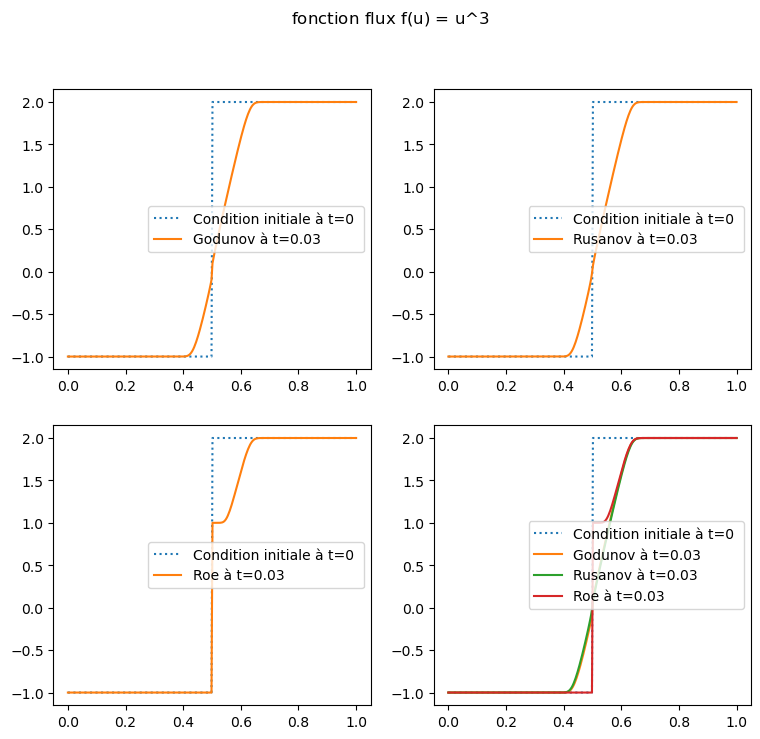

In [302]:
# Paramètres temporels
t , n  = 0 , 0 
T = 0.03
FD_Godunov ,FG_Godunov = np.zeros(J) , np.zeros(J)
FD_Rusanov , FG_Rusanov = np.zeros(J) ,  np.zeros(J) 
FD_ROE , FG_ROE  = np.zeros(J) , np.zeros(J)
# Boucle temporelle
while t < T:
    
    # Calcul des vitesses maximales
    vmax_G = max(abs(df(u_G)))
    vmax_R = max(abs(df(u_R)))
    vmax_ROE = max(abs(df(u_ROE)))
    
    # Calcul du pas de temps
    dt_G =dx / (2 * vmax_G)
    dt_R = dx / (2 * vmax_G)
    dt_ROE = dx / (2 * vmax_ROE)
    dt = min(dt_G,dt_R, dt_ROE, T - t)
    cfl = dt / dx
      

    for j in range(1, J + 1):
   ################ Flux de Godunov#########################
        FG_Godunov[j - 1] = Flux_Godunov(u_G[j - 1], u_G[j])
        FD_Godunov[j - 1] = Flux_Godunov(u_G[j], u_G[j + 1])
   ###################### Flux de Rusanov ###########################
        FG_Rusanov[j-1] = Flux_Rusanov(u_R[j-1] , u_R[j])
        FD_Rusanov[j-1] = Flux_Rusanov(u_R[j] , u_R[j+1] )
   ######################## Flux de Roe #################################
        FG_ROE[j-1] = Flux_Roe(u_ROE[j-1] , u_ROE[j])
        FD_ROE[j-1] = Flux_Roe(u_ROE[j] , u_ROE[j+1] )
   ################## Calcul du schema #################################                               
    u_G[1:-1] -=cfl*(FD_Godunov-FG_Godunov)
    u_R[1:-1] -=cfl*( FD_Rusanov- FG_Rusanov)
    u_ROE[1:-1] -=cfl*( FD_ROE- FG_ROE)

  ############## Condition au limite de type Neumann et Periodique #######################  
    u_G = Neumann(u_G)  # Appliquer les conditions aux limites
    u_R = Neumann(u_R) 
    u_ROE = Neumann(u_ROE) 

    #u_G = Periodique(u_G)  # Appliquer les conditions aux limites
    #u_R = Periodique(u_R) 
    #u_ROE = Periodique(u_ROE) 
    
    n += 1
    t = n * dt

    #print(t)
 
################ Validation ##################
plt.figure(figsize=(9,8))
plt.suptitle(r"$\text{fonction flux f(u) = u^3}$")
# plt.suptitle('Fonction cubique')
plt.subplot(221)
plt.plot(xx, u0, label=f'Condition initiale à t=0 ', linestyle=":") 
plt.plot(xx, u_G, label=f'Godunov à t={T}')       #
plt.legend()
plt.subplot(222)
plt.plot(xx, u0, label=f'Condition initiale à t=0 ', linestyle=":") 
plt.plot(xx, u_R, label=f'Rusanov à t={T}')
plt.legend()
plt.subplot(223)
plt.plot(xx, u0, label=f'Condition initiale à t=0 ', linestyle=":") 
plt.plot(xx, u_ROE, label=f'Roe à t={T}') 
plt.legend()
plt.subplot(224)
plt.plot(xx, u0, label=f'Condition initiale à t=0 ', linestyle=":") 
plt.plot(xx, u_G, label=f'Godunov à t={T}') 
plt.plot(xx, u_R, label=f'Rusanov à t={T}')
plt.plot(xx, u_ROE, label=f'Roe à t={T}') 
plt.legend()
plt.show()

